In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *
from mpl_toolkits.mplot3d import Axes3D
import itertools
%matplotlib notebook

# Fonction Affines

Une fonction affine est une fonction de la forme:
\begin{align}
f(x)=ax+b
\end{align}

Supposons que nous étudions une propriété physique **mesurée** $y$ qui dépend linéairement d'une autre propriété **descriptive** $x$. Par exemple, $x$ pourrait être la concentration de nanotubes de carbonne dans un alliage métalique et $y$ la solidité de l'alliage.

Le **descripteur** $x$ est une quantité que nous pouvons choisir, et la **mesure** $y$ est une quantité que nous pouvons mesurer expérimentalement ou simuler. Les constantes $a$ et $b$ sont des paramètres du **modèle** que nous ne connaisons pas à priori car le systême est trop compliqué pour les déduire. 
Cependant, si nous avons assez de données $x$ et $y$, nous pouvons les **apprendre** avec des algorithmes. On peut ensuite utiliser le modèle pour **prédire** les valeurs de y associer à de nouvelles valeurs du descripteur $x$. Par exemple, nous connaissons la solidité de l'alliage pour les concentrations en nanotubes $0.12\%$, $0.47\%$ et $0.83\%$, et nous aimerions prédire la solidité d'un alliage avec une concentration $0.24\%$.

La fonction ci-dessous génére un nombre aléatoire $a\in [low;high]$, qui fera office de paramètre du modèle inconnu à priori.

In [2]:
def rand_in(low,high):
    return (high-low)*np.random.random()+low

Définir un vecteur $x$ contenant une dizaine de valeurs aléatoire dans l'interval $[0;1]$, une fonction affine avec $b=0$ et $a \in [1;5]$ généré aléatoirement.
Calculer $y=f(x)$ et tracer les points (x,y) avec la fonction plt.scatter. 

<IPython.core.display.Javascript object>


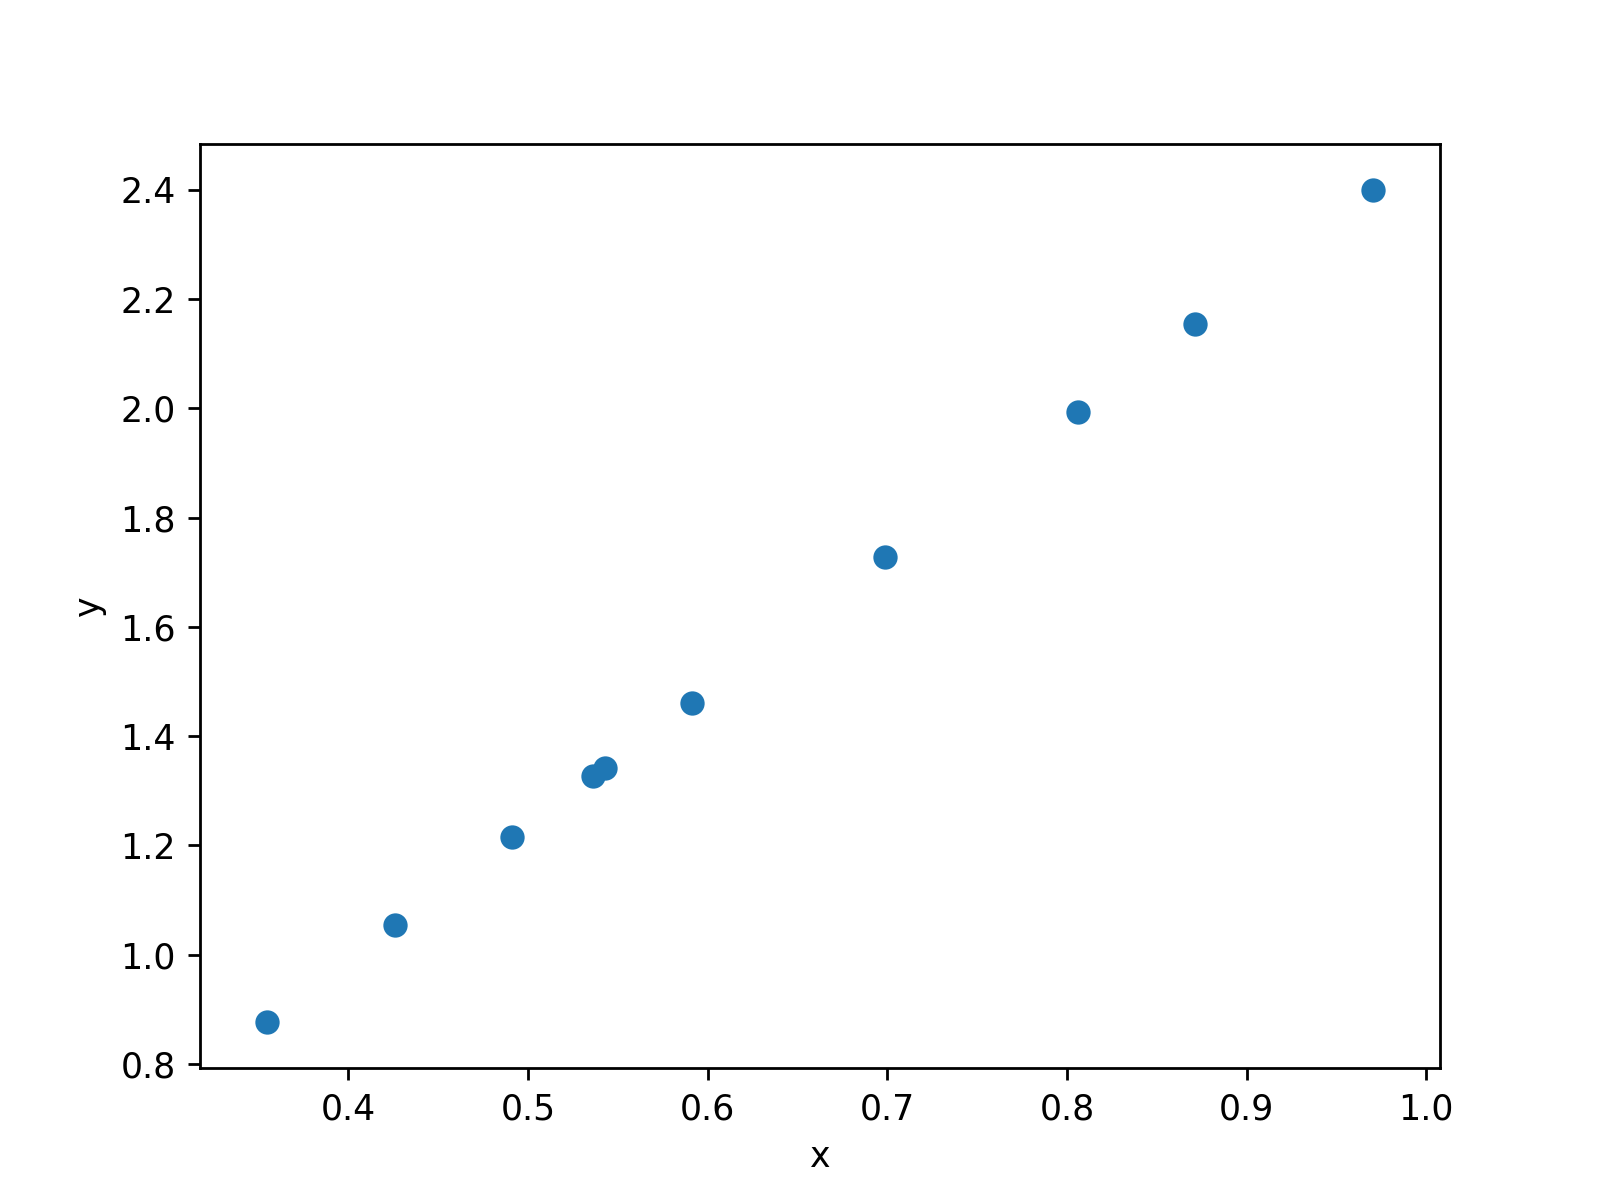

In [4]:
a=rand_in(5,1)
x=np.random.random(10)
y=a*x

#plot
fig=plt.figure()
ax=fig.add_subplot(111, xlabel='x',ylabel='y')
ax.scatter(x,y)
plt.show()

Retrouver la valeur de $a$ à partir des valeurs de $x$ et $y$ (sans faire "print(a)"!!).
Pour vérifier, tracer la ligne représentant la fonction affine $f(x)=ax$ avec plt.plot, en plus des points (x,y).

<IPython.core.display.Javascript object>


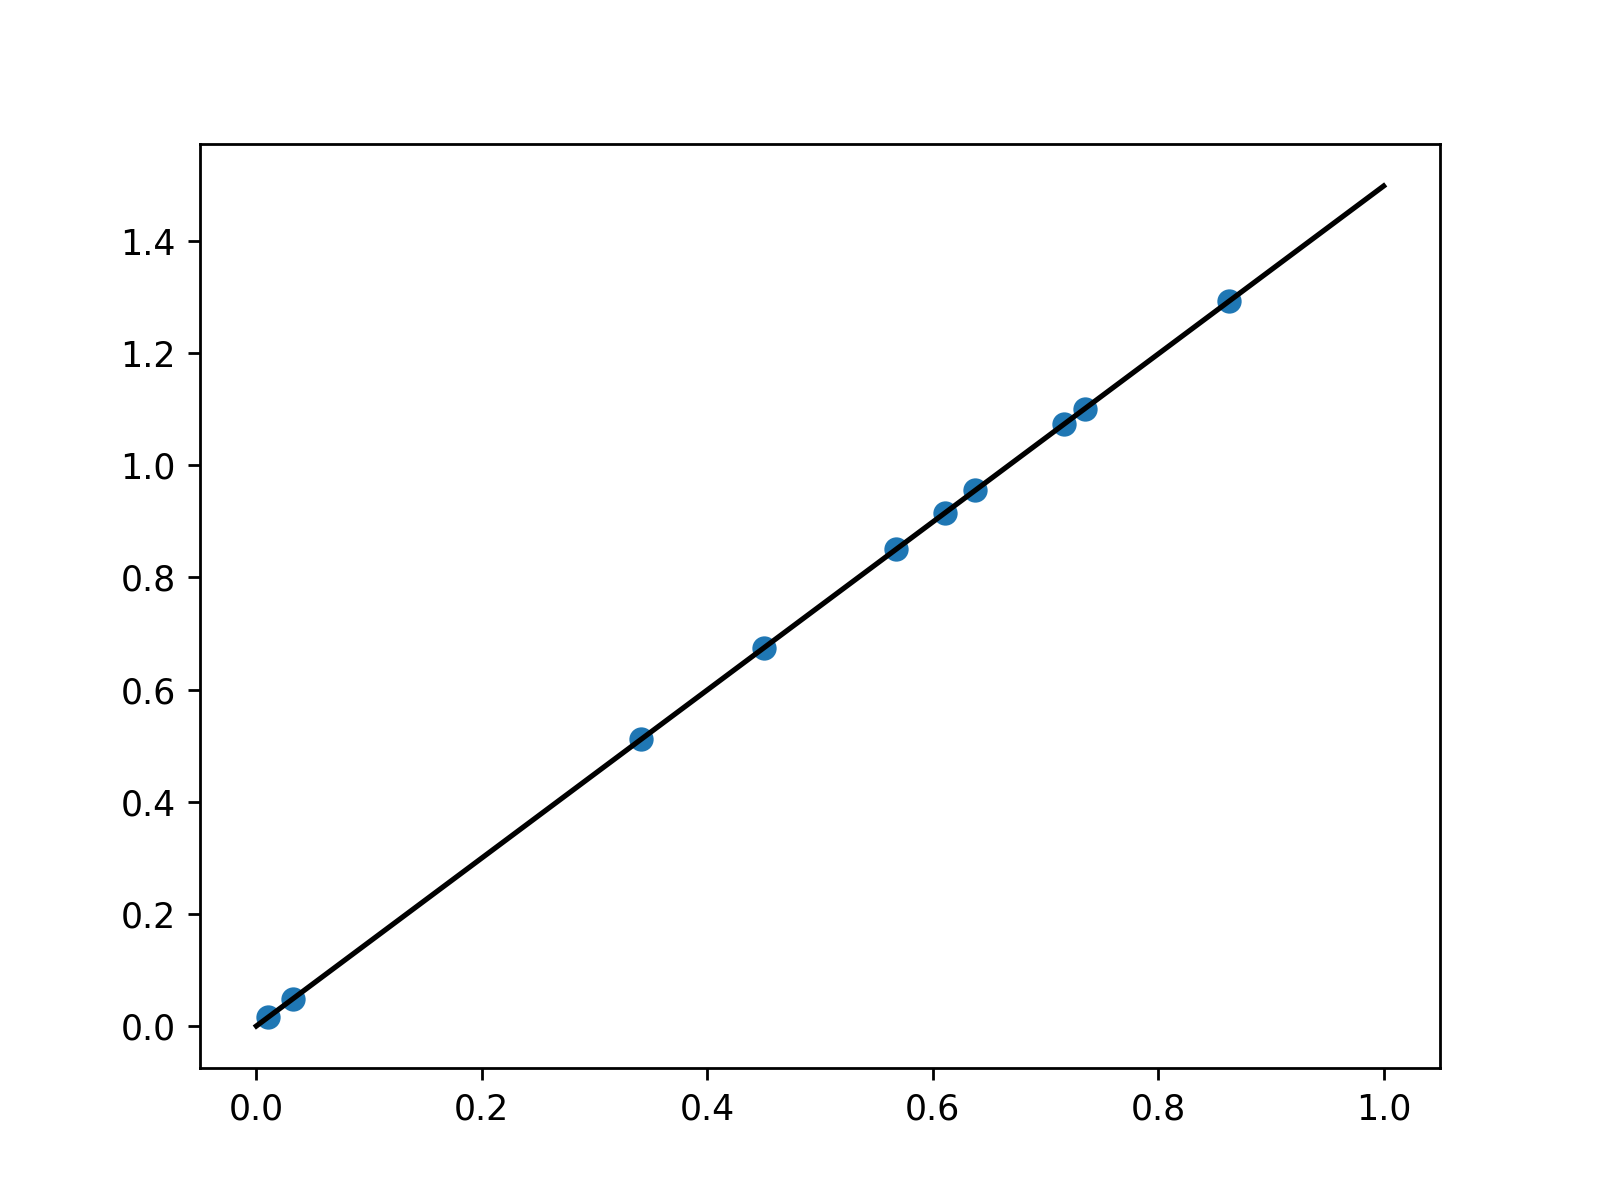

In [4]:
pente=(y[0]/x[0])
xx=np.linspace(0,1,10)
yy=pente*xx

#plot
fig=plt.figure()
ax=fig.add_subplot(111, xlabel='x',ylabel='y')
ax.plot(xx,yy, color='k')
ax.scatter(x,y)
plt.show()

# Régression linéaire

En pratique, les choses ne collent pas aussi bien... $f$ ne représente pas parfaitement la réalité, c'est un **modèle**. D'autres facteurs peuvent affecter les **mesures** $y$. Par exemple, pour une même concentration de nanotubes de carbone, leur disposition peut varier suivant les détails de la préparation de l'alliage. Ceci ajoute de bruit aux données.

Ci-dessous, on ajoute artifiellement du bruit aux données: On génere une autre pente  $a$ , des points x aléatoires, et des valeurs  $y=ax+s$  ou s est un nombre aléatoire généré grace à une distribution normale centrée en  $0$  et de variance  $0.2$  (différent pour chaque valeur de x).

<IPython.core.display.Javascript object>


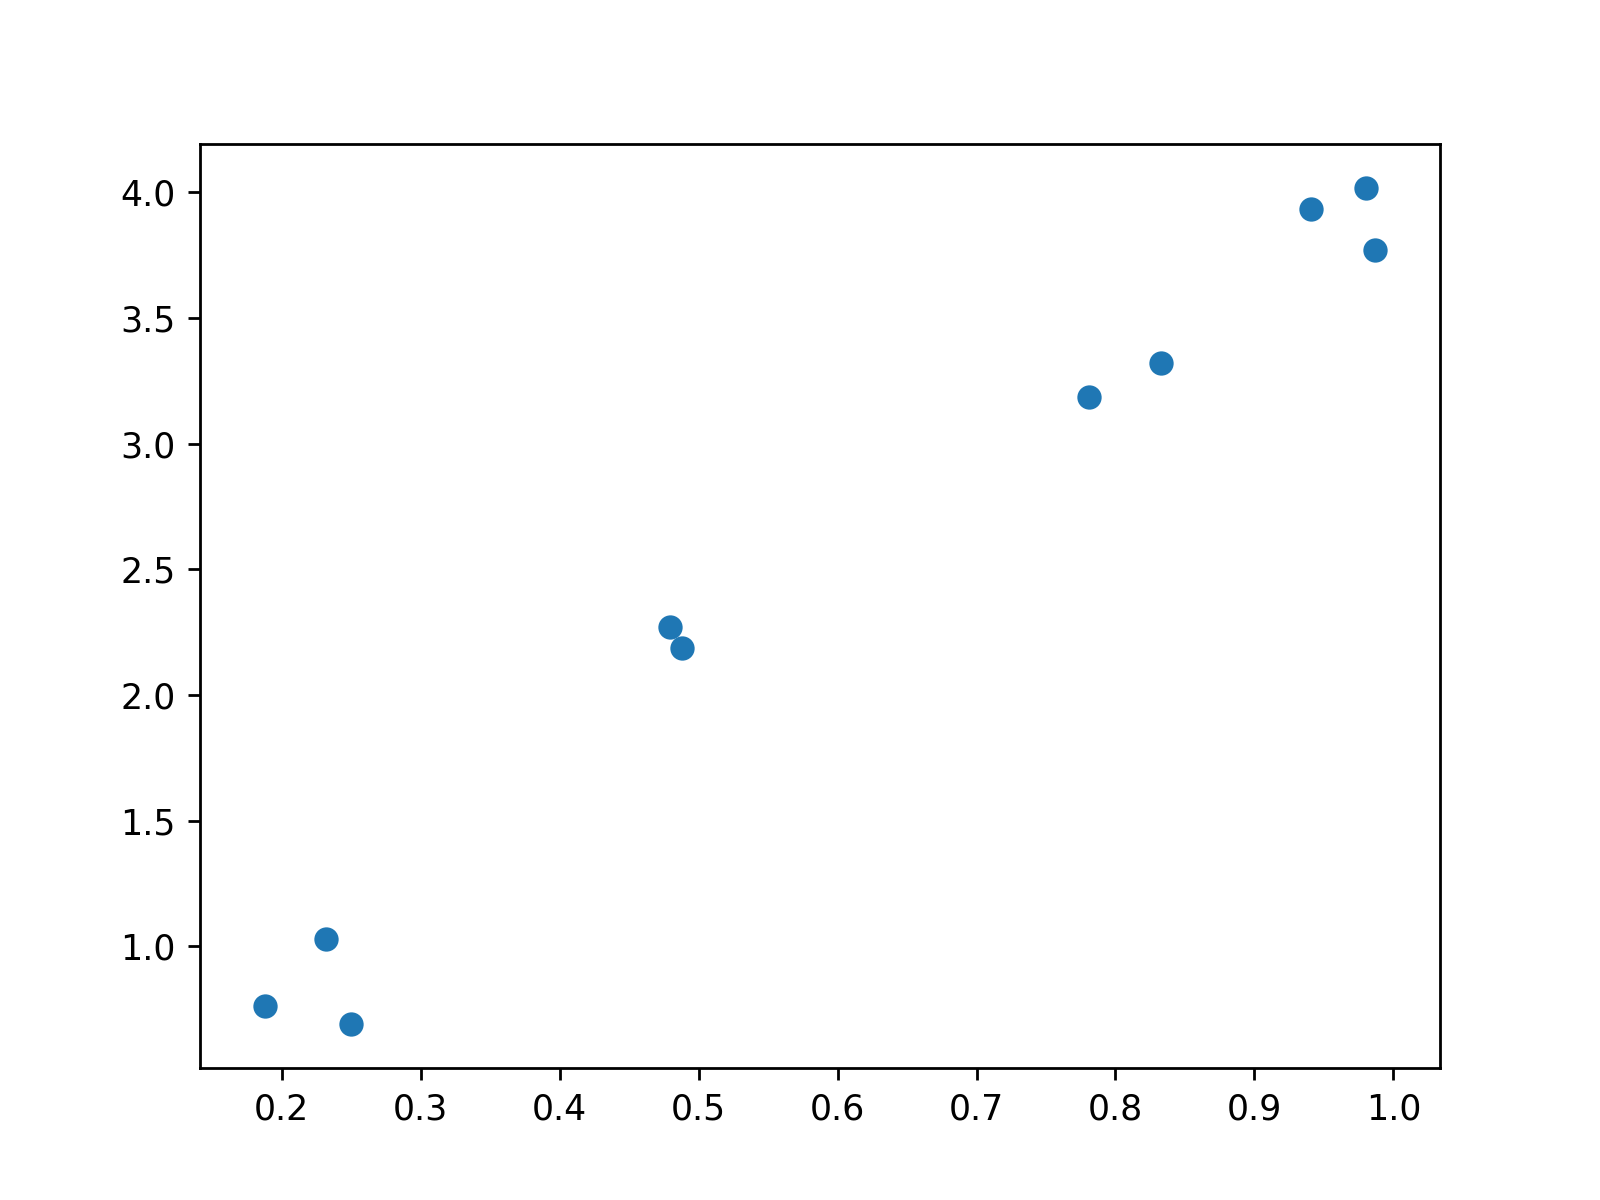

In [40]:
a=rand_in(1,5)
x=np.random.random(10)
y=a*x+np.array([np.random.normal(scale=0.2) for i in range(len(x))])

#
fig=plt.figure()
ax=fig.add_subplot(111,xlabel='x',ylabel='y')
ax.scatter(x,y)
plt.show()

La cellule ci-dessous trace une fonction affine dont la pente est un nombre entier $a$ réglable. Faire glisser la barre ci-dessous pour changer la pente de la droite tracée et estimer la valeur de $a$ qui représente le mieux les données, et qui permettrait de faire la meilleure prédiction.

In [6]:
## here they can use the slider to change the slope of the line until it fits the points best
@interact(a=2)
def plot_line(a):
    fig=plt.figure()
    ax=fig.add_subplot(111,xlabel='x',ylabel='y')
    ax.scatter(x,y)
    xx=np.linspace(0,1,3)
    ax.plot(xx,a*xx)
    plt.show()
    return

A Jupyter Widget

Ici, nous avons effectuer (à l'oeil) une **régression linéaire**. On a estimé le paramètre du modèle qui reproduit au mieux les données, c'est à dire qui minimise la distance entre les **prédictions** $ax$ et les **mesures** $y$. 

On va maintenant rendre cette procédure plus systématique, en commençant par définir un **coût** comme la distance entre prédictions et mesures:
\begin{equation}
S(a)=\sum_i (y_i-ax_i)^2 
\end{equation}
où $x_i$ et $y_i$ correspondent aux valeurs de $x$ et $y$ pour chaque point de données dont on dispose.

Pourquoi utilise-t-on la différence au carré?

Écrire une fonction "cost" qui calcule la quantité $S(a)$, en comparant une fonction affine de pente a et les mesures $y$.
Tracer la courbe correspondant à $S(a)$ pour $a \in [1;5]$

<IPython.core.display.Javascript object>


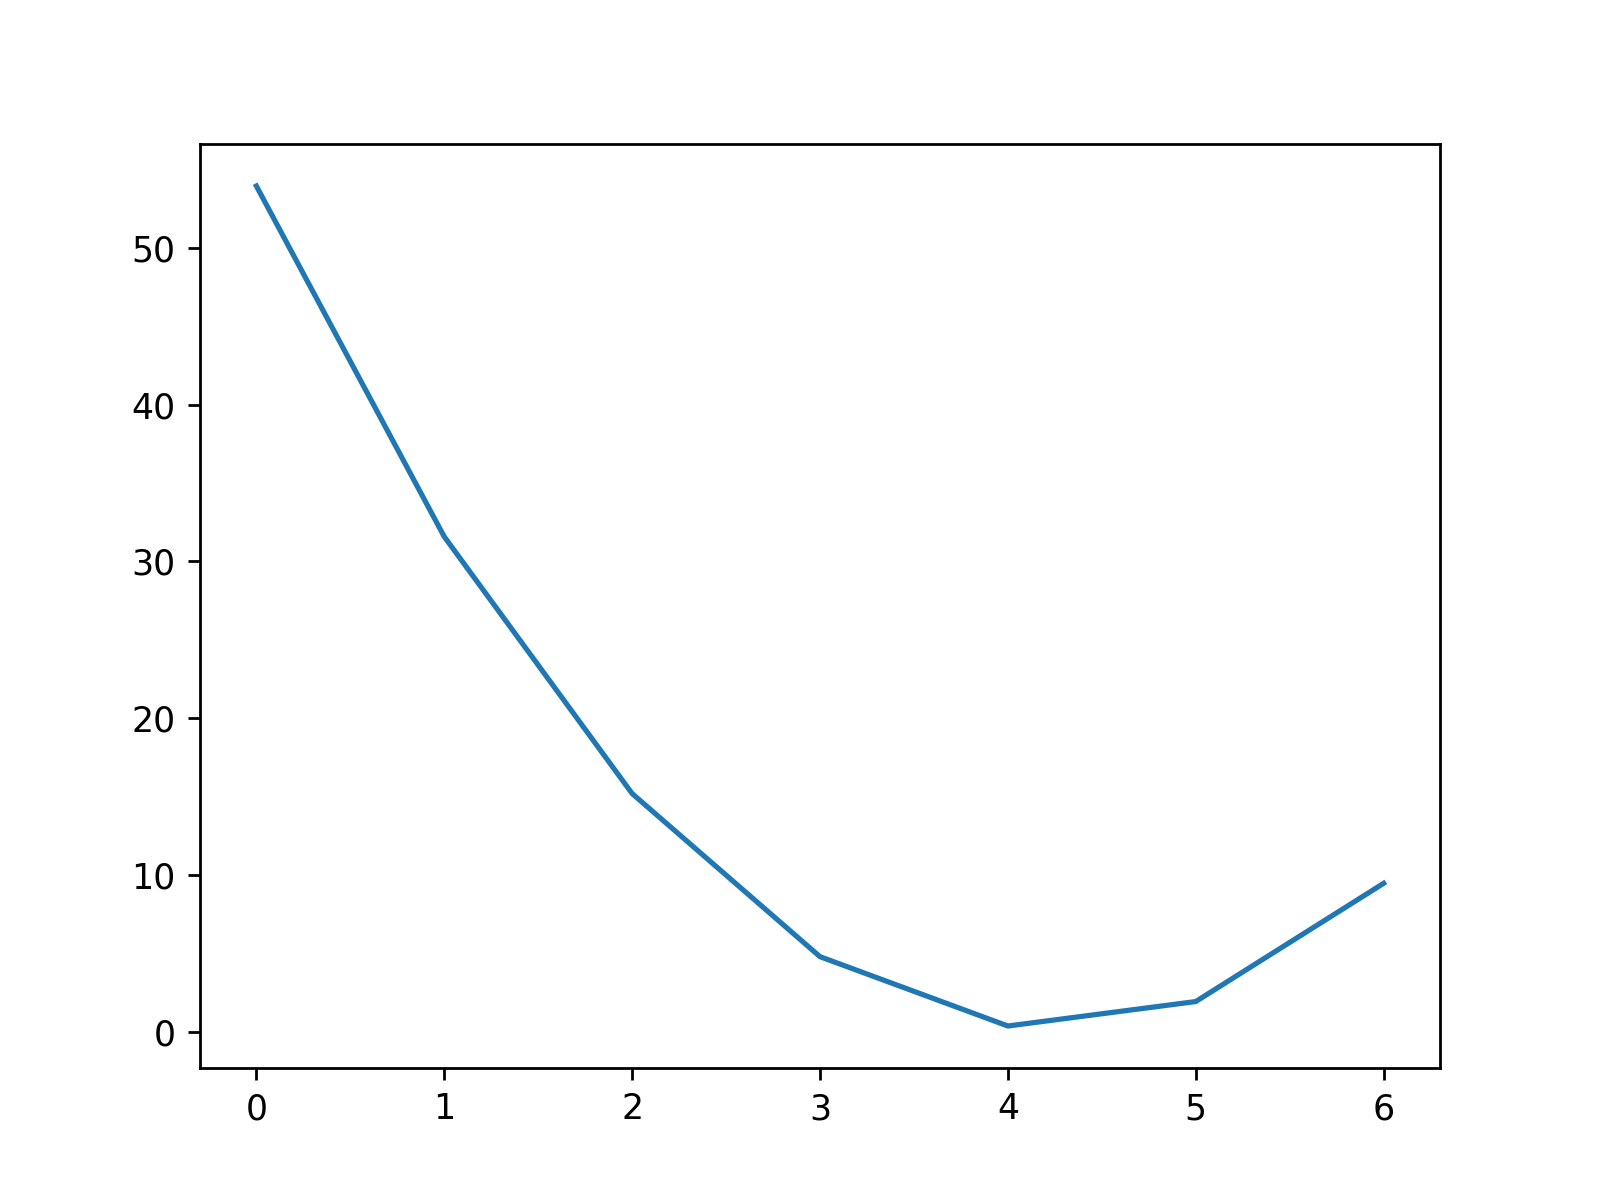

In [7]:
def cost(a,x, y):
    yn=a*x
    return np.sum((y-yn)**2)

# plot
pentes=[0,1, 2, 3, 4, 5, 6]
fig=plt.figure()
ax=fig.add_subplot(111,xlabel='a',ylabel='S')
ax.plot(pentes, [cost(p,x,y ) for p in pentes])
plt.show()

Nous devons maintenant miniser le **coût** $S(a)$, c'est-à-dire trouver la pente $a$ qui donne la plut petite erreur. 
Écrire une fonction qui, à partir d'une list de pentes à essayer et des points $x$ et $y$ , trouve la meilleures pente dans la liste, c'est à dire celle qui donne le plus petit coût.

In [8]:
def best_slope(a_list,x,y):
    return min(a_list, key=lambda z: cost(z,x,y))

#test
print(best_slope([0.,1.0,2.0,3.0,4.0],x,y),best_slope([2.8,3.0,3.2, 3.3, 3.4],x,y))

4.0 3.4


Nous allons effectuer une régression linéaire simplifiée comme suit:
- Partir d'un interval donné.
- Prendre $N$ valeur de pente equidistantes dans cette interval.
- Trouver la meilleure en utilisant la fonction ci-dessus.
- Recommencer en prenant comme nouvel interval celui défini par les 2 valeurs de pente autour de la meilleure 

L'algorithme s'arretera lorsque on sait que la meilleure pente se trouve dans un interval plus petit qu'un certain palier.
Ecrire les fonctions nécessaires. Ajouter un compteur qui copmte le nombre total de pentes essayées, ce qui nous donnera une idée du coup de notre algorithme.
Est-t-il une bonne idée de prendre $N$ grand? 

In [9]:
# fonction pour générer N pentes dans un interval donné:
# inputs:  rng=[low,high], N
# outputs: alist=[a1, a2, ..., aN] compris dans l'interval [low,high] et régulièrement espacés
def a_list(rng, N):
    return np.linspace(rng[0],rng[1],N)

# fonction pour trouver la résolution associée à un certain interval:
# inputs:  rng=[low,high], N
# outputs: différence entre 2 pentes consécutives
def Da(rng, N):
    return abs(rng[1]-rng[0])/N

# régression linéaire: 
# inputs: données x et y, un palier thr, un interval initial init_rng, 
#         le nombre de pentes à prendre dans chaque interval N
# outputs: la pente trouvée ba, le résultat du compteur count 
def simple_lreg(x,y,thr, init_rng, N):
    # initialisation
    rng=init_rng
    count=0
    # Boucle while, qui s'arrête lorsque la résolution des pentes est plus petite que thr.
    while Da(rng,N) > thr:
        # on génére la liste des pentes à essayer
        alist= a_list(rng, N)
        # on les essaye et on trouve la meilleure
        ba=best_slope(alist,x,y)
        # compteur
        count+=len(alist)
        # on met à jour l'interval en le rétrécissant autour de la meilleure pente.
        rng=[ba-Da(rng,N),ba+Da(rng,N)]
    return ba, count

In [10]:
simple_lreg(x,y,0.0001,[1.,5.],7)

(4.2391322209850193, 49)

In [11]:
simple_lreg(x,y,0.0001,[1.,5.],20)

(4.2392631578947366, 80)

# Variable multi-dimensionelle

Supposons maintenant que la propriété que nous voulons prédire $y_i$ dépend de 2 variables descriptives $x_{1,i}, x_{2,i}$. Par exemple, la solidité de l'alliage dépend de la concentration et de la longueur moyenne des nanotubes de carbone. On dit que notre variable descriptive $x$ a 2 dimensions.

On suppose toujours que l'on peut approximativement représenter leur relation linéairement, en faisant la somme des 2 fonctions affines : 
\begin{align}
y_i&\approx a_1 x_{1,i}+a_2 x_{2,i} \\
\end{align}
La distance des prédictions aux mesures est défini de la même manière, mais elle dépend cette fois de 2 paramètres:
\begin{align}
S(a_1, a_2)&=\sum_i (y_i-(a_1 x_{1,i}+a_2 x_{2,i}))^2
\end{align}
Pour effectuer une régression linéaire et trouver les meilleures valeurs de $a_1$ et $a_2$, on doit toujours minimiser la coût $S(a_1, a_1)$. 

Ecrire une fonction "cost2d" qui calcule $S(a_1, a_1)$ pour une fonction $f$ à 2 variables.

In [6]:
def cost2d(a,x, y):
    yn=a[0]*x[0,:]+a[1]*x[1,:]
    return np.sum((y-yn)**2)

Ci-dessous, on génére 2 pentes aléatoires $a_1$ et $a_2$ (toujours entre $1$ et $5$), et 100 valeurs de $x_1$ et $x_2$ aléatoires entre $0$ et $1$, et les valeurs de $y$ correspondantes, avec une erreur gaussienne de variance $\sqrt{2} \times 0.2$ (la racine de 2 veut dire que chaque dimension de $x$ apport une erreur gaussiene de variance $0.2$). 

Générer 2 listes de pentes à essayer, et calculer $S(a_1, a_2)$ pour chaque couple de pente parmis ces listes. Tracer ensuite, dans un plot 3D, la surface associée à la fonction $S(a_1, a_2)$ pour des valeurs de $a_1$ et $a_2$ entre $1$ et $5$.

<IPython.core.display.Javascript object>


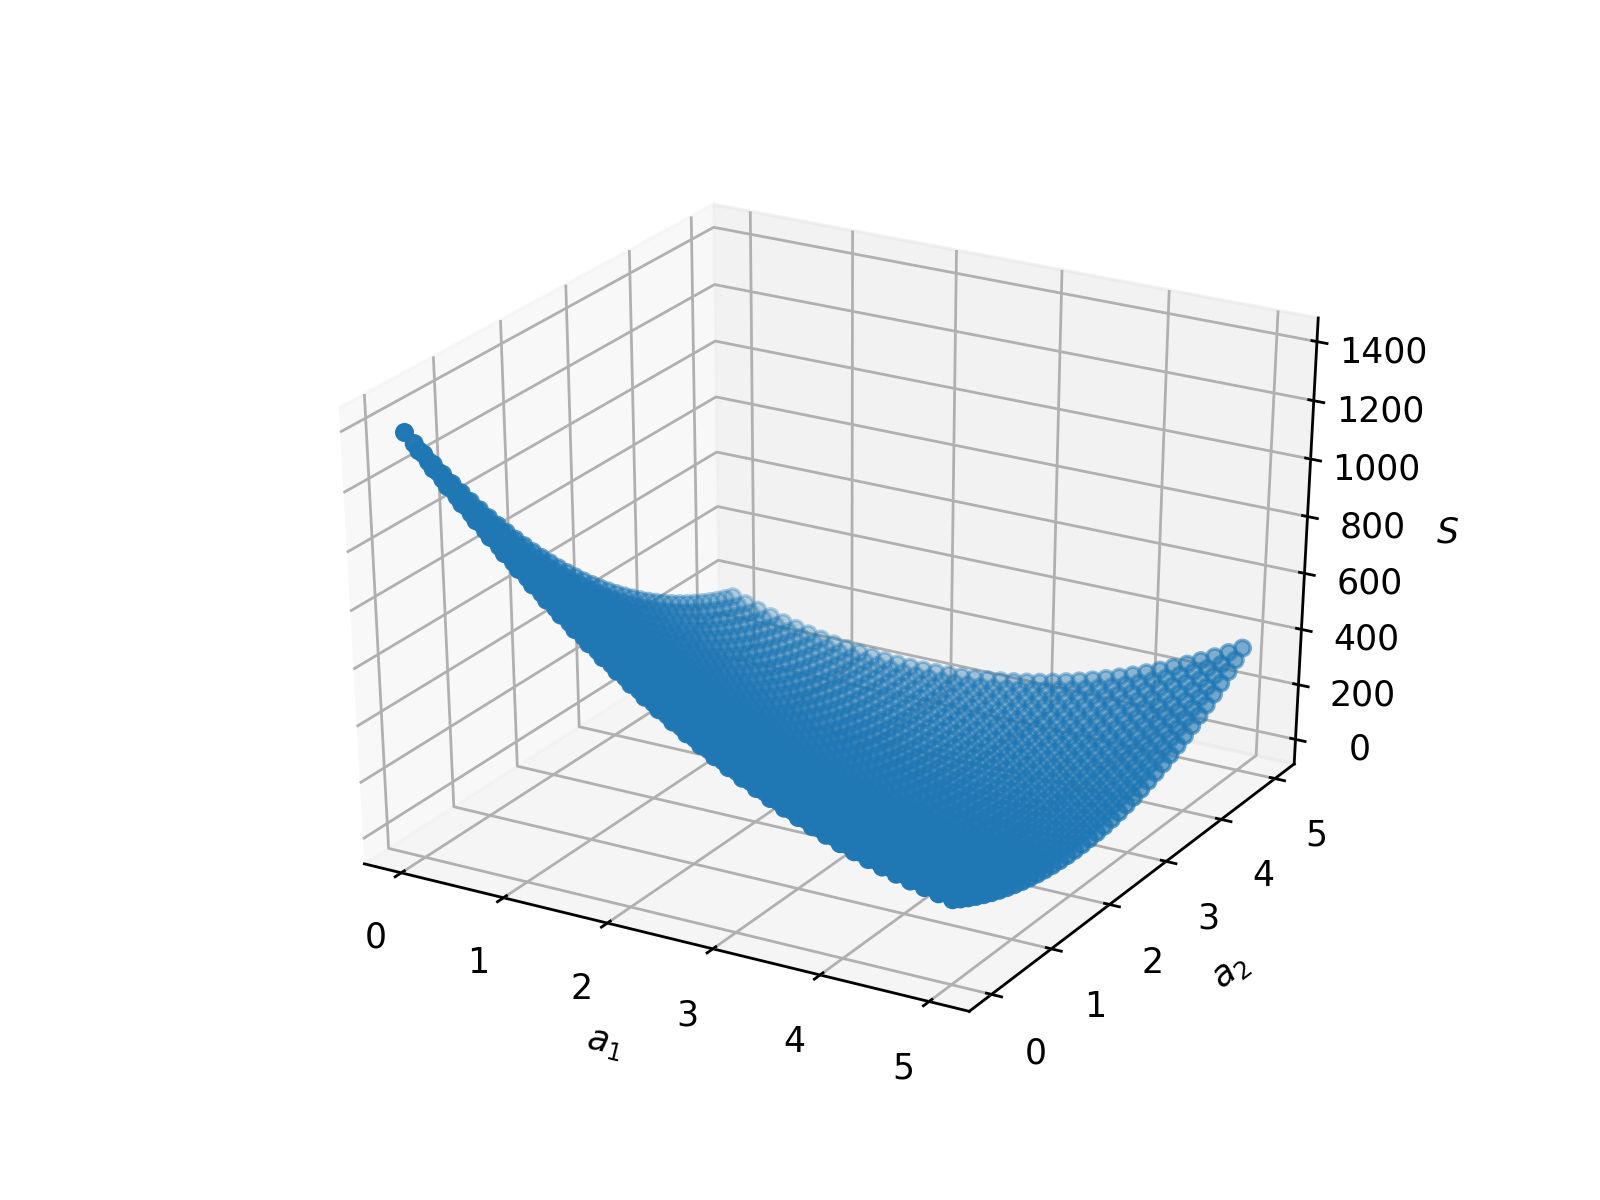

In [7]:
Nx=100
a=np.array([rand_in(1,5), rand_in(1,5)])
x=np.array([np.random.random(Nx),np.random.random(Nx)])
y=a[0]*x[0,:]+a[1]*x[1,:]+np.array([np.random.normal(scale=0.2*np.sqrt(2)) for i in range(Nx)])

pentes=np.linspace(0,5,40)
data=np.array([[p1,p2,cost2d([p1,p2],x,y)] for p1,p2 in itertools.product(pentes, pentes)] )

# plot
fig=plt.figure()
ax=plt.subplot(111,projection='3d',xlabel=r'$a_1$',ylabel=r'$a_2$',zlabel=r'$S$')
ax.scatter(data[:,0],data[:,1],data[:,2])
plt.show()

Adapter la regression linéaire écrite plus haut pour gérer un descripteur à 2 dimensions.

In [15]:
def best_slope2D(alist,x,y):
    a_init=np.array([0.,0.]) 
    lowestcost=cost2d(a_init,x,y)
    best=a_init
    for a1 in alist[0]:
        for a2 in alist[1]:
            c=cost2d([a1, a2], x,y)
            if c < lowestcost:
                lowestcost=c
                best=[a1,a2]
    return best
def Da2D(rng, N):
    return [abs(rng[0][1]-rng[0][0])/N,abs(rng[1][1]-rng[1][0])/N]
def simple_lreg2D(x,y,thr, init_rng, N):
    rng=init_rng
    count=0
    while max(Da2D(rng,N)) > thr:
        alist=np.array([np.linspace(rng[0][0],rng[0][1],N), np.linspace(rng[1][0],rng[1][1],N)])
        ba=best_slope2D(alist,x,y)
        count+=N**2
        D=Da2D(rng,N)
        rng=[[ba[0]-D[0],ba[0]+D[0]],[ba[1]-D[1],ba[1]+D[1]] ]
    print("after trying ",count," slopes")
    return ba, count

In [19]:
print(a)
simple_lreg2D(x,y,0.0001,[[-1,6.],[-1,6.]],7)

[ 4.56313993  2.83164936]
after trying  392  slopes


([4.6767149175371951, 2.8694520707074997], 392)

Ce que l'on a fait pour 1 puis 2 dimensions du descripteur "$x$" peut être généralisé à $N_{var}$ dimensions. 
Voici une version à $N_{var}$ dimensions de l'algorithme utilisé jusqu'a present:

In [10]:
def costNd(a,x, y):
    yn=sum(ai*xi for ai, xi in zip(a,x))
    return np.sum((y-yn)**2)

def best_slopeND(alist,x,y):
    lowestcost=costNd(alist[:,0],x,y)
    best=alist[:,0]
    for ax in itertools.product(*alist):
            c=costNd(ax, x,y)
            if c< lowestcost:
                lowestcost=c
                best=ax
    return best
def DaND(rng, N):
    return [abs(r[1]-r[0])/N for r in rng]
def simple_lregND(x,y,thr, init_rng, N):
    rng=init_rng
    count=0
    while max(DaND(rng,N)) > thr:
        alist=np.array([np.linspace(r[0],r[1],N) for r in rng])
        ba=best_slopeND(alist,x,y)
        count+=N**len(alist)
        rng=[[b-D,b+D] for b,D in zip(ba, DaND(rng,N)) ]
    print("after trying ",count," slopes")
    return ba, count

Ci dessous on génère $2000$ mesures pour un descripteur à 5 dimensions. 
Le modèle inclut 5 pentes aléatoires, et les mesures $y$ contiennent du bruit.

Effectuer la régression linéaire et comparer les paramètre du modèle trouvées aux pentes générée.

In [11]:
Nvar=5
Np=2000
A=np.array([rand_in(1,5) for i in range(Nvar)])
X=np.array([np.random.random(Np) for i in range(Nvar)]).T
Y=np.dot(X,A)+np.array([np.random.normal(scale=np.sqrt(Nvar)*0.2) for i in range(Np)])

In [12]:
print(A)
Adum, nslo=simple_lregND(X.T,Y,0.0001,[[1.,5.]]*Nvar,7)
Afit=np.array(Adum)
print(Afit)

[ 2.71532189  4.86849437  1.83032808  1.1801744   1.7711719 ]
after trying  117649  slopes
[ 2.76181126  4.83692736  1.80145178  1.20375864  1.77143027]


0.000909572375334


<IPython.core.display.Javascript object>


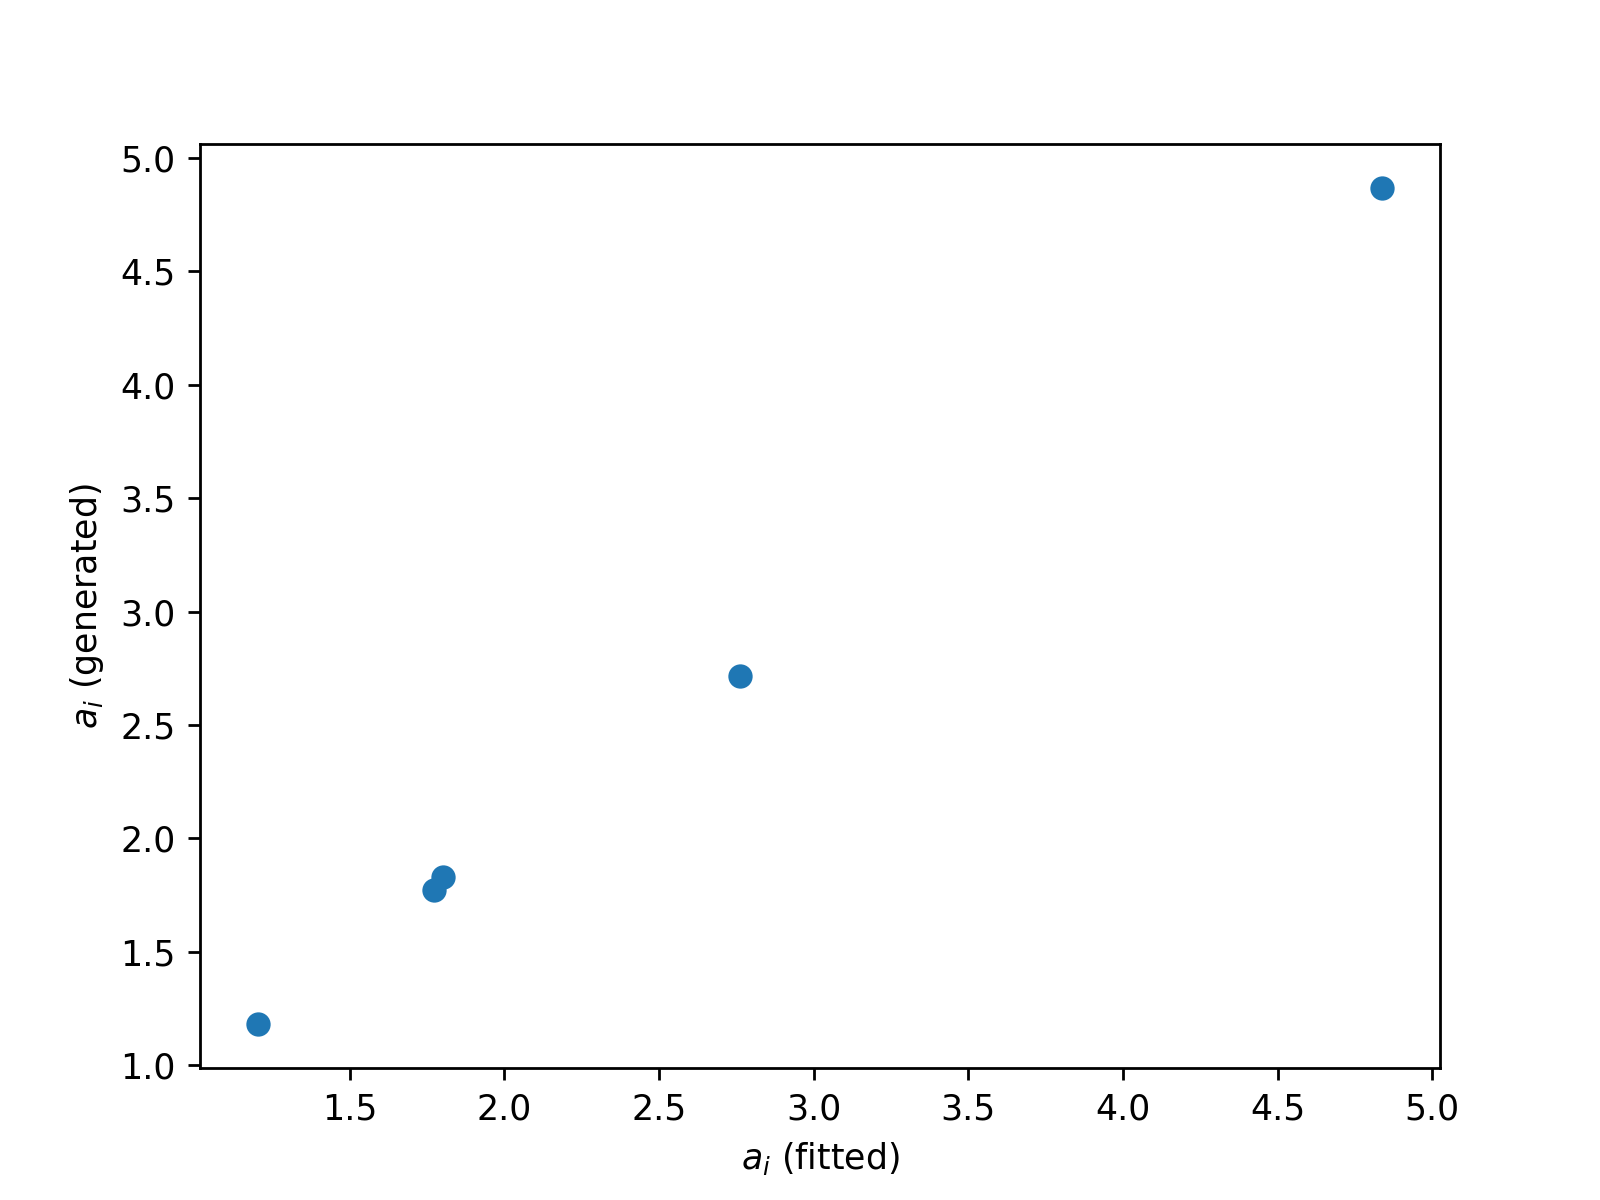

In [13]:
print(np.sum((A-Afit)**2)/Nvar)
fig=plt.figure()
ax=plt.subplot(111,xlabel=r'$a_i$ (fitted)',ylabel=r'$a_i$ (generated)')
ax.scatter(Afit,A)
plt.show()

# Entrainement

Le nombre de points de données (descripteur+mesure) disponibles accroit la qualité de la régression linaire.

In [24]:
Nvar=5
A=np.array([rand_in(1,5) for i in range(Nvar)])

<IPython.core.display.Javascript object>


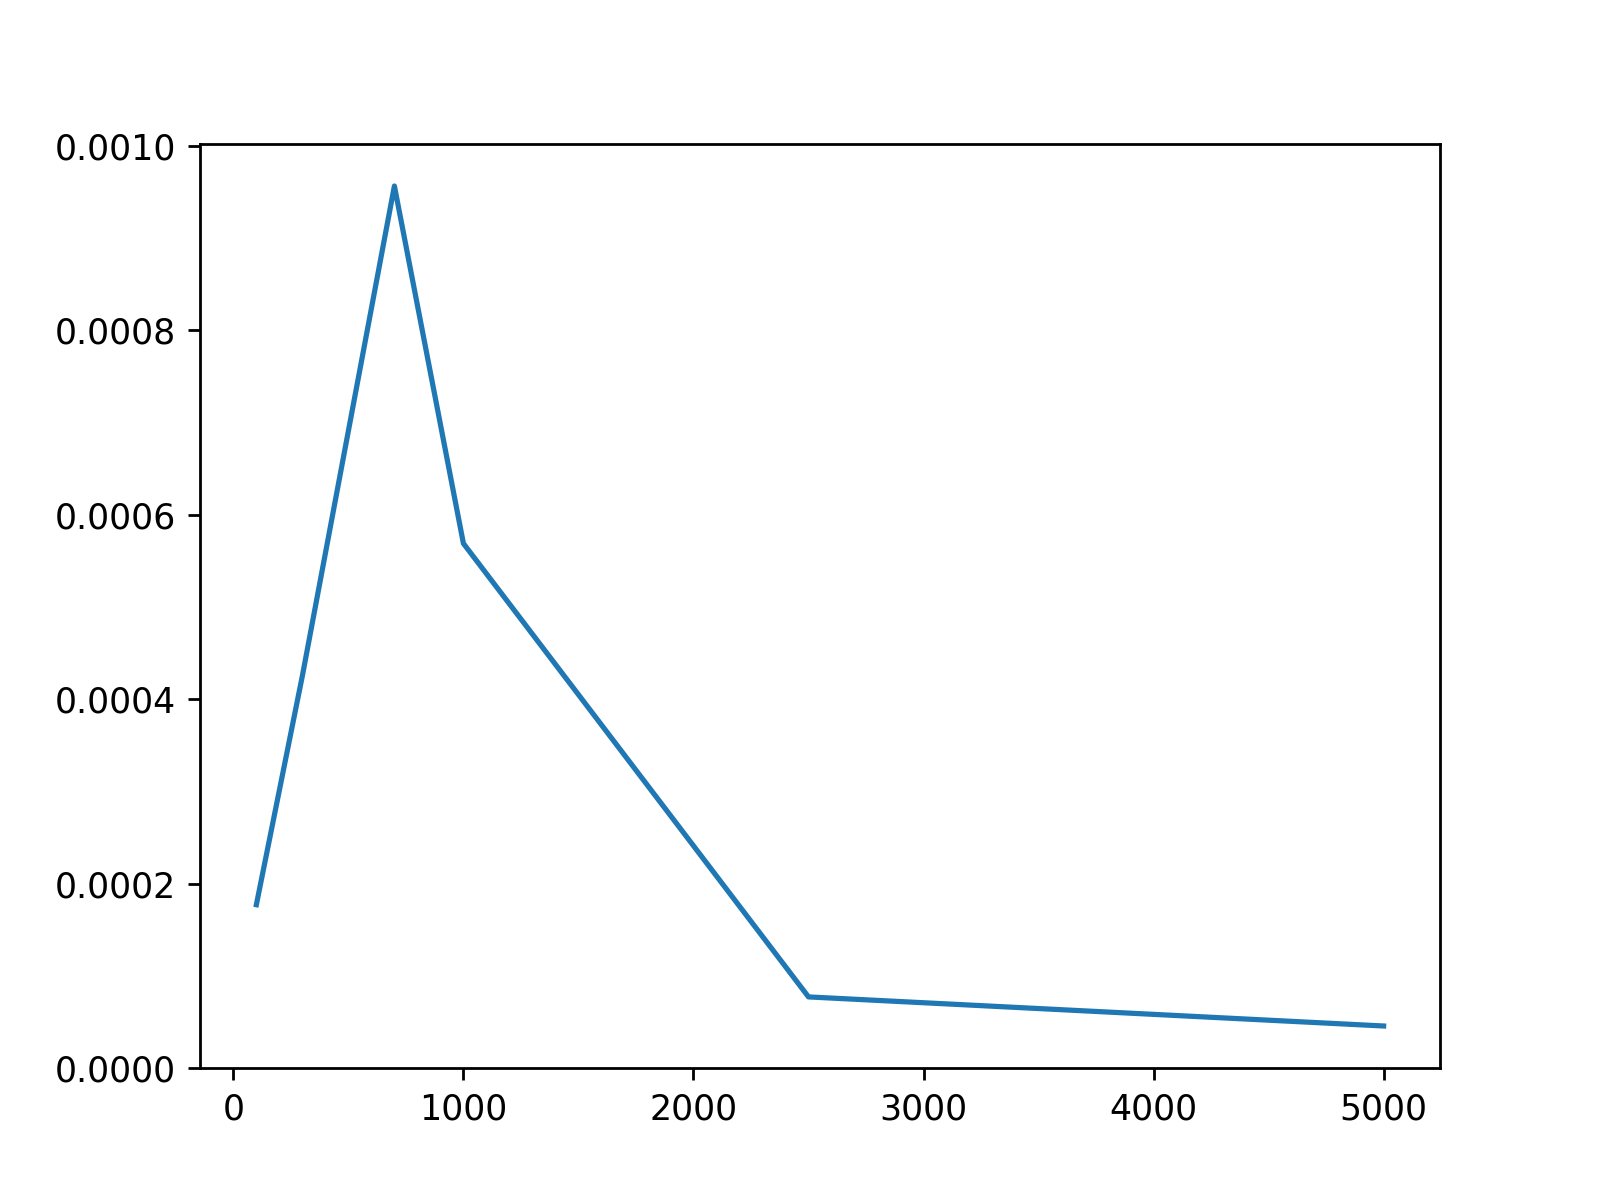

after trying  117649  slopes
after trying  117649  slopes
after trying  117649  slopes
after trying  117649  slopes
after trying  117649  slopes
after trying  117649  slopes


In [25]:
fig=plt.figure()
ax=plt.subplot(111,xlabel=r'nombre de données',ylabel=r'erreur')
Nps=[ 100,300,700, 1000, 2500, 5000]
errors=[]
for Np in Nps:
    X=np.array([np.random.random(Np) for i in range(Nvar)]).T
    Y=np.dot(X,A)+np.array([np.random.normal(scale=0.2) for i in range(Np)])
    Adum, nslo=simple_lregND(X.T,Y,0.0001,[[1.,5.]]*Nvar,7)
    Afit=np.array(Adum)
    errors.append(np.sum((A-Afit)**2)/Nvar)
ax.plot(Nps,errors)
plt.show()

# Entrainement et test

On considère un descripteur à 5 dimensions prenant 1000 valeurs entre $0$ et $1$, ainsi que $1000$ valeures d'une mesure $y$ qui dépend linéairement des $x_i$ avec des pentes $a_i$ entre $1$ et $5$ à estimer.

In [9]:
Np=1000
Nvar=5
A=np.array([rand_in(1,5) for i in range(Nvar)])
X=np.array([np.random.random(Np) for i in range(Nvar)]).T
Y=np.dot(X,A)+np.array([np.random.normal(loc=np.rint(2*(float(i)-Np/2)/Np),scale=1.0) for i in range(Np)])

Nous séparons l'ensemble de 1000 points de données en 2 parties: 

- 800 points de données pour entrainer notre regression linéaire
- 200 points pour la tester

Comment choisir les données d'entrainement?
Commencer par simplement sélectionner les 800 premiers points de données. Effectuer la régression et la tester en plottant les prédictions et les valeurs de $y$ pour les 200 points de test sur le même graph. 

In [14]:
Ntr=800
Xtr=X[:Ntr,:]
Ytr=Y[:Ntr]
Xte=X[Ntr:,:]
Yte=Y[Ntr:]
Adum, nslo=simple_lregND(X.T,Y,0.0001,[[1.,5.]]*Nvar,7)
Afit=np.array(Adum)

after trying  117649  slopes


<IPython.core.display.Javascript object>


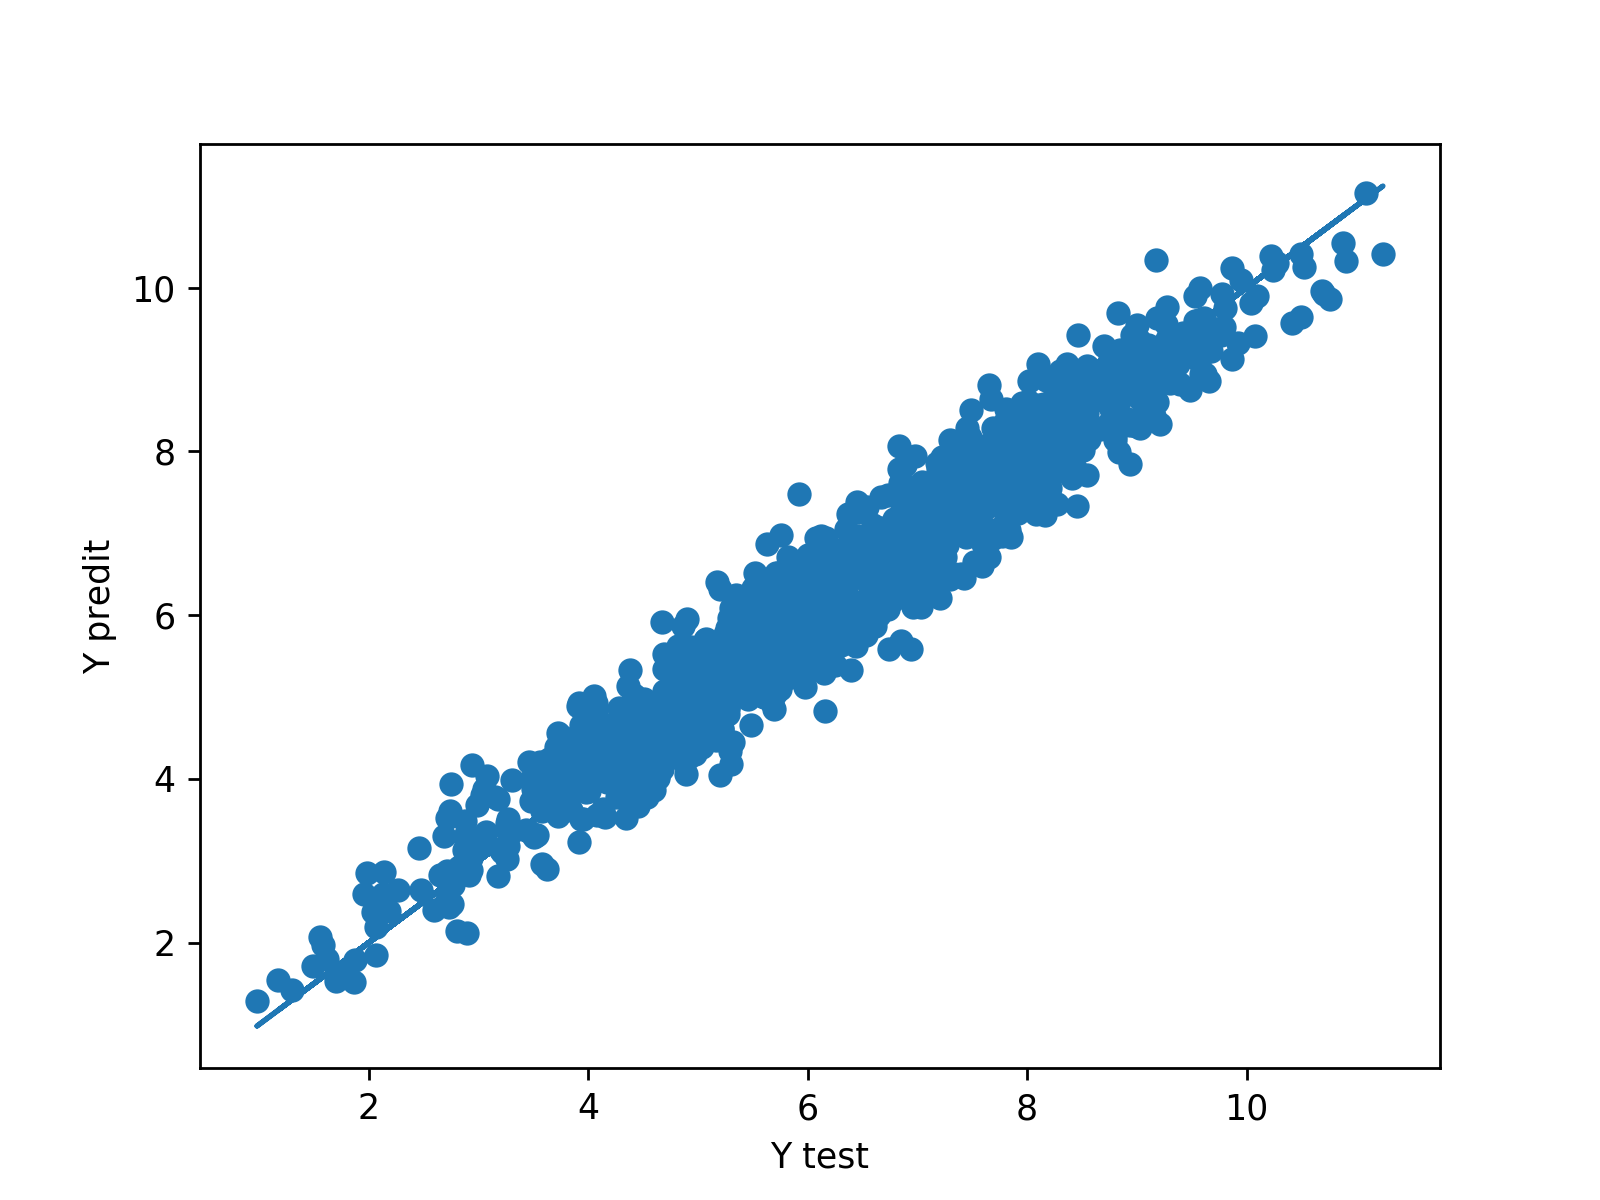

0.447927321215


In [16]:
fig=plt.figure()
ax=plt.subplot(111,xlabel='Y test', ylabel='Y predit')
ax.scatter(Yte,np.dot(Xte,Afit))
ax.plot(Yte, Yte)
print(np.sqrt(np.sum((Yte-np.dot(Xte,Afit))**2)/len(Yte)))
plt.show()

La qualité de la régression n'est pas optimale. C'est parce que nos données incluent un léger biais, en fonction de leur position dans le vecteur. Comme nous ne prenons que le début du vecteur, la régression ne marche pas bien pour la fin. Pour remédier à cela, il suffit de choisir les 800 points d'entrainement au hasard.

In [29]:
indices = np.random.permutation(Np)
training_idx, test_idx = indices[:Ntr], indices[Ntr:]
Xtr, Xte = X[training_idx,:], X[test_idx,:]
Ytr, Yte = Y[training_idx], Y[test_idx]
Adum, nslo=simple_lregND(X.T,Y,0.0001,[[1.,5.]]*Nvar,7)
Afit=np.array(Adum)

after trying  117649  slopes


<IPython.core.display.Javascript object>


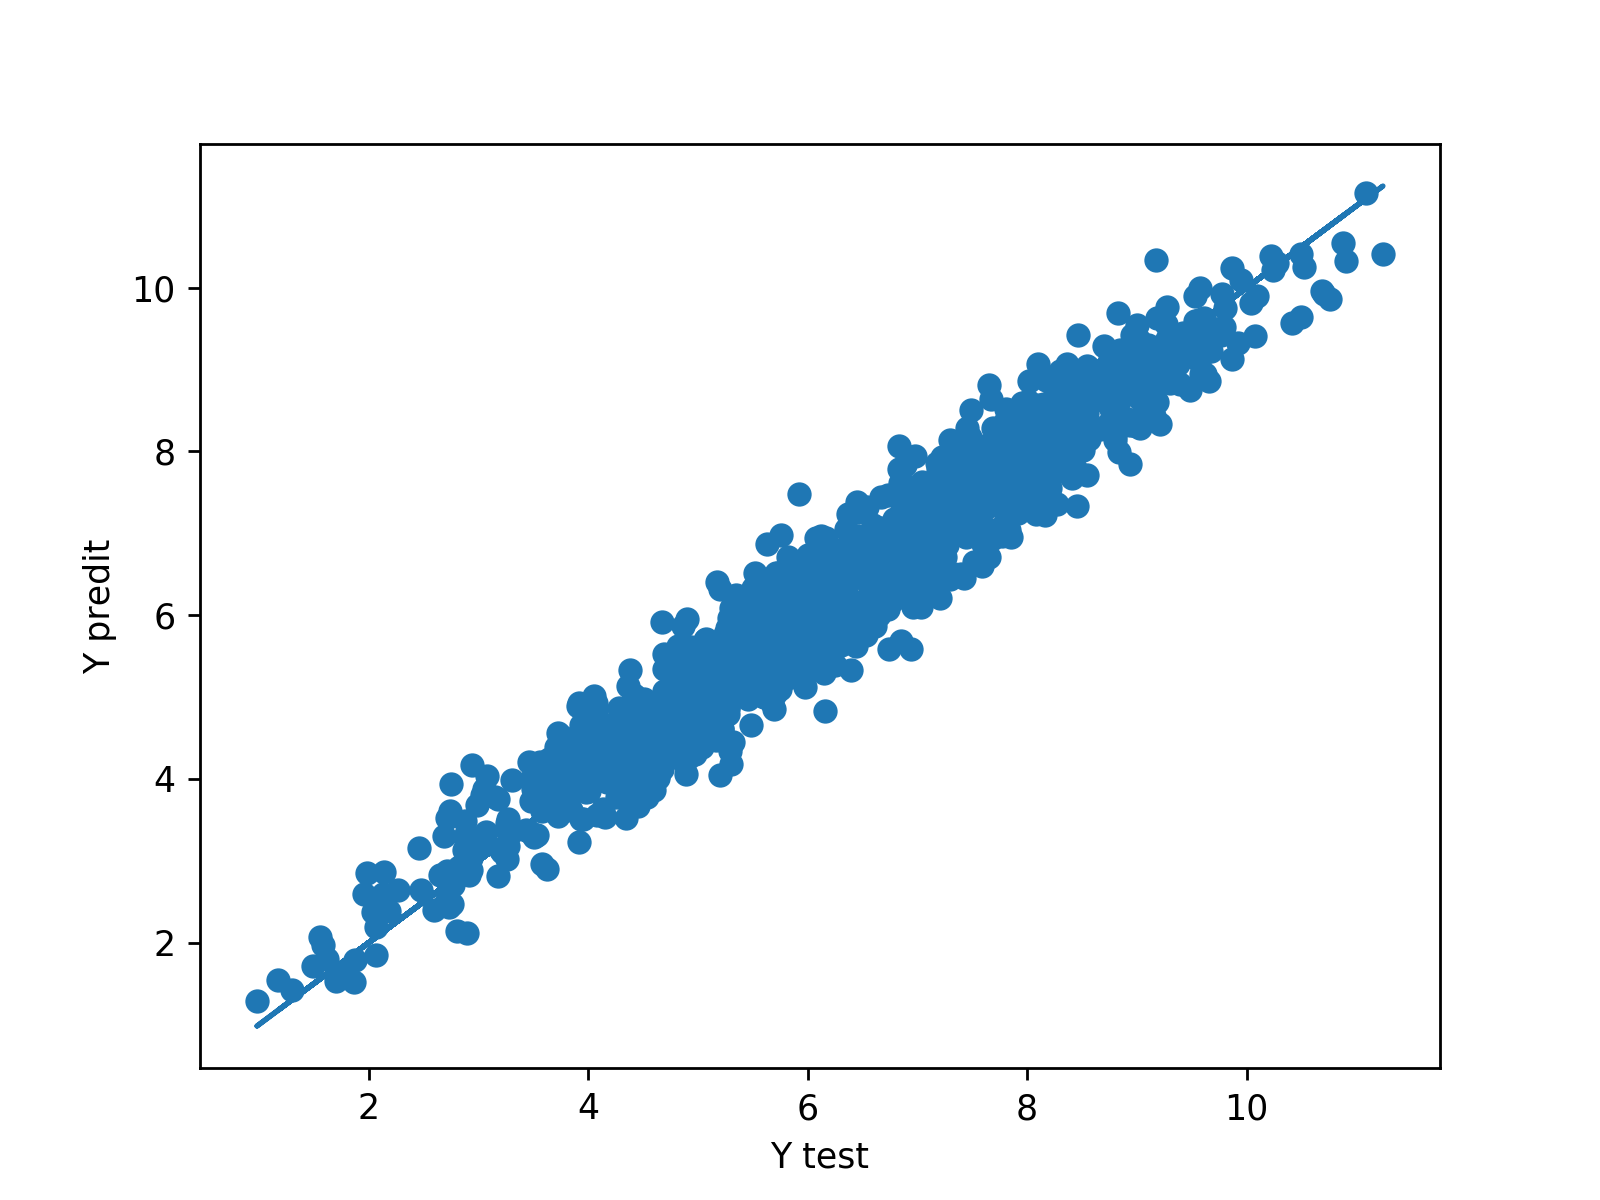

0.447927321215


In [17]:
fig=plt.figure()
ax=plt.subplot(111,xlabel='Y test', ylabel='Y predit')
ax.scatter(Yte,np.dot(Xte,Afit))
ax.plot(Yte, Yte)
print(np.sqrt(np.sum((Yte-np.dot(Xte,Afit))**2)/len(Yte)))
plt.show()

<IPython.core.display.Javascript object>


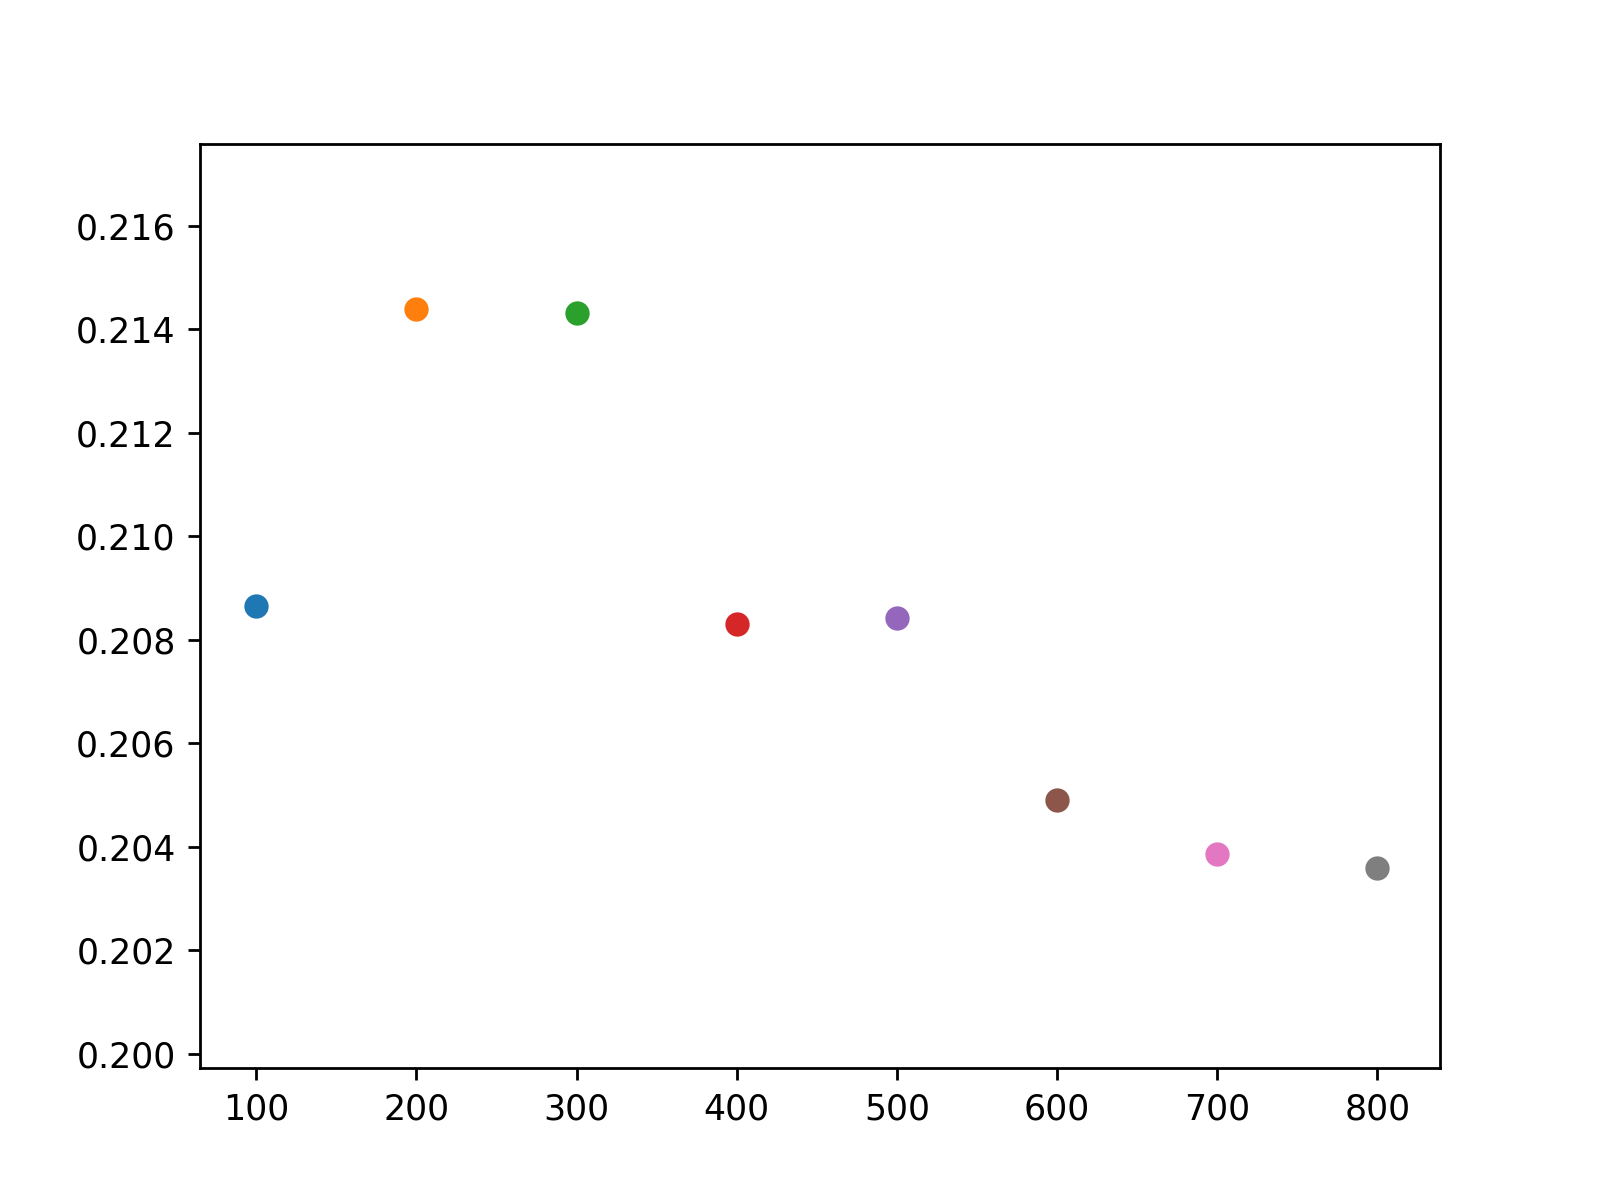

after trying  117649  slopes
after trying  117649  slopes
after trying  117649  slopes
after trying  117649  slopes
after trying  117649  slopes
after trying  117649  slopes
after trying  117649  slopes
after trying  117649  slopes


In [19]:
fig=plt.figure()
ax=plt.subplot(111)
Ntrs=np.arange(100, 900, 100)
for Ntr in Ntrs:
    Xtr=X[:Ntr,:]
    Ytr=Y[:Ntr]
    Xte=X[-100:,:]
    Yte=Y[-100:]
    Adum, nslo=simple_lregND(Xtr.T,Ytr,0.0001,[[1.,5.]]*Nvar,7)
    Afit=np.array(Adum)
    ax.scatter(Ntr,np.sum((Yte-np.dot(Xte,Afit))**2)/len(Yte))
plt.show()

# Bonus (si le temps et la motivation le permet)

Il y a des méthodes plus formelles pour effectuer des régressions linéaires.

Si nous reprenons la version à une dimension:

Nous avons des points $x_i$ et des mesures $y_i$, et l'on suppose que l'on peut approximativement représenter leur relation avec une fonction affine (sans constante): 
\begin{align}
y_i&\approx cte \times x_i \\
\end{align}
Avec $a$, on obtient des prédictions $\hat{y}_i$
\begin{align}
\hat{y}_i&=a x_i\\
\end{align}
avec une erreur $\epsilon_i$ dont veut miniser la somme des carrés $S(a)$:
\begin{align}
\epsilon_i&=\hat{y}_i-y_i\\
S(a)&=\sum_i \epsilon_i^2
\end{align}
On doit trouver le minimum de la fonction $S(a)$. La fonction $S(a)$ est minimal lorsque sa dérivé par rapport à $a$ s'annule (voir le tracé de $S(a)$ plus haut)
\begin{align}
\frac{dS(a)}{da}&=\frac{d\sum_i \epsilon_i^2}{da}=0
\end{align}
En dérivant l'expression ci-dessus, on obtient:
\begin{align}
\frac{d\sum_i (y_i-a x_i)^2}{da}&=\sum_i x_i (y_i-a x_i)=0 \\
\sum_i x_i y_i&=a \sum_i x_i^2 \\
a&=\frac{\sum_i x_i y_i}{\sum_i x_i^2}
\end{align}
Vérifier que l'on trouve un nombre similaire avec cette formule.

De même pour la version à 2 dimensions

La fonction $S(a_1, a_2)$ est minimal lorsque sa dérivé par rapport à $a_1, a_2$ s'annule:
\begin{align}
\frac{dS(a_1)}{da}&=\frac{dS(a_2)}{da}=0
\end{align}
En dérivant les expressions ci-dessus, on obtient:
\begin{align}
\sum_i x_{1,i} (y_i-a_1 x_{1,i}-a_2 x_{2,i})=0 \\
\sum_i x_{2,i} (y_i-a_1 x_{1,i}-a_2 x_{2,i})=0 \\
\end{align}
Ce qui nous donne un système de 2 équations à 2 inconnues: 
\begin{align}
\sum_i x_{1,i}y_i=a_1 \sum_i x^2_{1,i}- a_2 \sum_i x_{1,i} x_{2,i} \\
\sum_i x_{2,i} y_i= a_1 \sum_i x_{2,i} x_{1,i}- a_2 \sum_i x^2_{2,i} \\
\end{align}
Il est alors plus pratique d'écrire le problème sous forme sous forme matricielle:
\begin{align}
\hat{Y}&= \hat{A} X\\
\end{align}
la minimisation des distances au carré revient à résoudre:
\begin{align}
0&=X^{T} (Y-\hat{A} X) \\
\hat{A} &= (X^{T} X)^{-1} X^{T}Y 
\end{align}
Cette dernière expression est générale et peut être appliquée à des dimensions plus élevées.

In [34]:
Nvar=5
Np=2000
A=np.array([rand_in(1,5) for i in range(Nvar)])
X=np.array([np.random.random(Np) for i in range(Nvar)]).T
Y=np.dot(X,A)+Nvar*np.array([np.random.normal(scale=0.2) for i in range(Np)])
Afit=np.dot( np.linalg.inv(np.dot(X.T,X)) , np.dot(X.T,Y) )

In [37]:
print(A, Afit)

array([ 4.4283295 ,  4.44636281,  1.75394812,  1.1433523 ,  4.87822496])